In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
library("phyloseq")
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)


In [200]:

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [4]:
%%R
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2200 taxa and 100 samples ]
sample_data() Sample Data:       [ 100 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2200 taxa by 8 taxonomic ranks ]


In [31]:
%%R
ps.FQS = subset_samples(physeq,sample_data(physeq)$Trtmt=="F"|sample_data(physeq)$Trtmt=="Q"|sample_data(physeq)$Trtmt=="S")

In [5]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>1000)

In [33]:
%%R
ps <- ps.FQS

In [34]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [45]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3, trymax=40)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1646447 
Run 1 stress 0.1626342 
... New best solution
... procrustes: rmse 0.06379594  max resid 0.451415 
Run 2 stress 0.164587 
Run 3 stress 0.1648356 
Run 4 stress 0.1626659 
... procrustes: rmse 0.03400311  max resid 0.2475691 
Run 5 stress 0.164802 
Run 6 stress 0.1645887 
Run 7 stress 0.1667089 
Run 8 stress 0.1625466 
... New best solution
... procrustes: rmse 0.01736175  max resid 0.1189309 
Run 9 stress 0.1632353 
Run 10 stress 0.1654442 
Run 11 stress 0.1666755 
Run 12 stress 0.1645729 
Run 13 stress 0.1628324 
... procrustes: rmse 0.03260634  max resid 0.2493134 
Run 14 stress 0.1629274 
... procrustes: rmse 0.01048575  max resid 0.07529716 
Run 15 stress 0.1630058 
... procrustes: rmse 0.02227935  max resid 0.1351049 
Run 16 stress 0.1657139 
Run 17 stress 0.1654358 
Run 18 stress 0.1625366 
... New best solution
... procrustes: rmse 0.004395386  max resid 0.02616916 
Run 19 stress 0.1745252 
Run 20 stress 0.1646435 
Run 21 stress 0.1665809 
Run 22 stress 0.

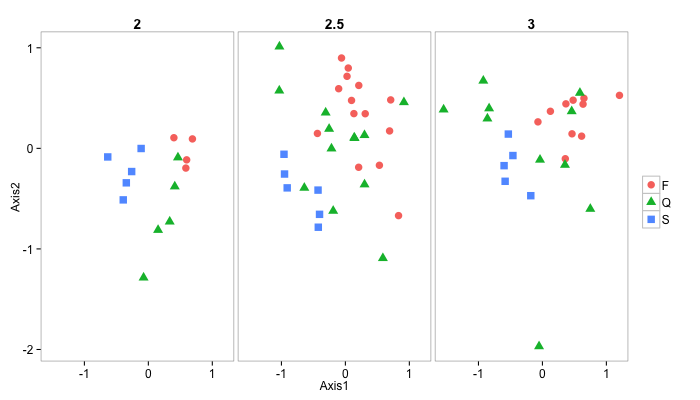

In [47]:
%%R -h 400 -w 700
D <- ord.full.plot
# Sets the relevant ordination

colnames(D)[1:2]<-c("Axis1","Axis2")
# Renames the axis columns

D$Month<-as.factor(D$Month)
D$Cosm<-as.factor(D$Cosm)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = Axis1, y = Axis2, color = Trtmt, shape = Trtmt))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 
#+ scale_colour_manual(values=c("skyblue3","orange","chartreuse4","gold1","red3","black"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
See Soil_Effect notebook. There is not a significant difference detected.